In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fastai.vision.all import *
from shopee_utils import *
import sklearn.metrics as skm
from tqdm.notebook import tqdm

from fastai.vision.learner import _resnet_split
import h5py

In [3]:
import debugpy
debugpy.listen(5678)

('127.0.0.1', 5678)

In [3]:
conf = {
    'bs':64,
    'arch':resnet50,
    'split':0
}

In [4]:
train_df = pd.read_csv(PATH/'train_split.csv')
train_df['is_valid'] = train_df.split==conf['split']

In [6]:
# def hash_label(x):
#     x = (13*x)%10000
#     return x // 2000
# train_df['split']=train_df.label_group.apply(hash_label)
# train_df.to_csv(PATH/'train_split.csv')

In [5]:
def get_img_file(row):
    img =row.image
    fn  = PATH/'train_images'/img
    if not fn.is_file():
        fn = PATH/'test_images'/img
    return fn

In [6]:
data_block = DataBlock(blocks = (ImageBlock(), CategoryBlock(vocab=train_df.label_group.to_list())),
                 splitter=ColSplitter(),
                 #splitter=RandomSplitter(),
                 get_y=ColReader('label_group'),
                 get_x=get_img_file,
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75),
                 )
dls = data_block.dataloaders(train_df, bs=conf['bs'],num_workers=16)

In [7]:
class ArcFaceClassifier(nn.Module):
    def __init__(self, in_features, output_classes):
        super().__init__()
        self.W = nn.Parameter(torch.Tensor(in_features, output_classes))
        nn.init.kaiming_uniform_(self.W)
    def forward(self, x):
        x_norm = F.normalize(x)
        W_norm = F.normalize(self.W, dim=0)
        return x_norm @ W_norm
    
    
def arcface_loss(cosine, targ, m=.5, s=30):
    cosine = cosine.clip(-1+1e-7, 1-1e-7) 
    arcosine = cosine.arccos()
    arcosine += F.one_hot(targ, num_classes = dls.c) * m
    cosine2 = arcosine.cos()
    cosine2 *= s
    return F.cross_entropy(cosine2, targ)

In [8]:

class F1FromEmbs(Callback):
    def after_pred(self):
        if not self.training:
            self.embs.append(self.learn.pred)
            self.ys.append(self.learn.yb[0])
            self.learn.yb = tuple()
    def before_validate(self):
        self.ys = []
        self.embs = []
        self.model.outputEmbs = True
    def before_train(self):
        self.model.outputEmbs = False
    def after_validate(self):
        embs = torch.cat(self.embs)
        ys = torch.cat(self.ys)
        score = f1_from_embs(embs,ys)
        learn.metrics[0].val = score

class FakeMetric(Metric):
    val =0.0
    @property
    def value(self):
        return self.val
    
    @property
    def name(self): 
        return 'F1 embeddings'

In [9]:
class ResnetArcFace(nn.Module):
    def __init__(self):
        super().__init__()
        self.body = create_body(conf['arch'], cut=-2)
        nf = num_features_model(nn.Sequential(*self.body.children()))
        self.after_conv=nn.Sequential(
            AdaptiveConcatPool2d(),
            Flatten(),
            nn.BatchNorm1d(nf*2),
            nn.Dropout(.25))
        self.classifier = ArcFaceClassifier(nf*2, dls.c)
        self.outputEmbs = False
    def forward(self, x):
        x = self.body(x)
        embeddings = self.after_conv(x)
        if self.outputEmbs:
            return embeddings
        return self.classifier(embeddings)

In [10]:



def arcface_loss(cosine, targ, m=.5, s=30):
    cosine = cosine.clip(-1+1e-7, 1-1e-7) 
    arcosine = cosine.arccos()
    arcosine += F.one_hot(targ, num_classes = dls.c) * m
    cosine2 = arcosine.cos()
    cosine2 *= s
    return F.cross_entropy(cosine2, targ)



In [11]:
def split_2way(model):
    return L(params(model.body),
            params(model.classifier))

In [12]:
learn = Learner(dls,ResnetArcFace(),splitter=split_2way, loss_func=arcface_loss, cbs = F1FromEmbs, metrics=FakeMetric())

In [ ]:
learn.fine_tune(10,1e-2)

epoch,train_loss,valid_loss,F1 embeddings,time
0,18.353197,None,0.696604,01:49


epoch,train_loss,valid_loss,F1 embeddings,time
0,14.302702,None,0.717996,02:06
1,12.638057,None,0.724334,02:07
2,11.567471,None,0.737275,02:09


In [49]:
learn.save('resnet34_arcface')

Path('models/resnet34_arcface.pth')

# VALIDATION Non arcface

In [50]:
model = learn.model.eval()
model.outputEmbs = True

In [ ]:
embs, y = embs_from_model(model, dls.valid)


0.780 at 4.938601493835449 pairs


0.7800704033339603

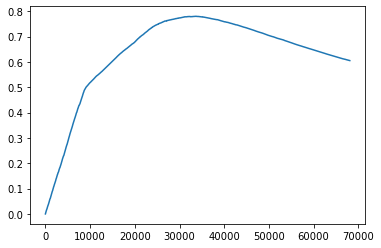

In [56]:
f1_from_embs(embs,y, True)